<a href="https://colab.research.google.com/github/GirolamoOddo/AppliedMath_Notebooks/blob/main/GeneticOptimization_for_StructuralDesign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generation 0: Best Fitness = 1.00, Displacement Fitness = 0.22, Material Usage Fitness = 0.46, Points = [[0.0, 0.0], [1.0, 0.0], [0.045916257099271544, 0.9252631994459787], [1.028478702576861, 0.8495098616440807]]
Generation 1: Best Fitness = 1.00, Displacement Fitness = 0.22, Material Usage Fitness = 0.47, Points = [[0.0, 0.0], [1.0, 0.0], [-0.0399794229561941, 0.9014468742420803], [1.0188420051286045, 0.944525018414669]]
Generation 2: Best Fitness = 0.72, Displacement Fitness = 0.16, Material Usage Fitness = 0.44, Points = [[0.0, 0.0], [1.0, 0.0], [-0.04080041000553973, 0.6560221712424608], [1.0711716072277748, 0.8595307574970255]]
Generation 3: Best Fitness = 0.78, Displacement Fitness = 0.18, Material Usage Fitness = 0.43, Points = [[0.0, 0.0], [1.0, 0.0], [0.0834687728868217, 0.7498459739948966], [1.0442074820151825, 0.8665105253248457]]
Generation 4: Best Fitness = 0.71, Displacement Fitness = 0.16, Material Usage Fitness = 0.44, Points = [[0.0, 0.0], [1.0, 0.0], [-0.013555394575

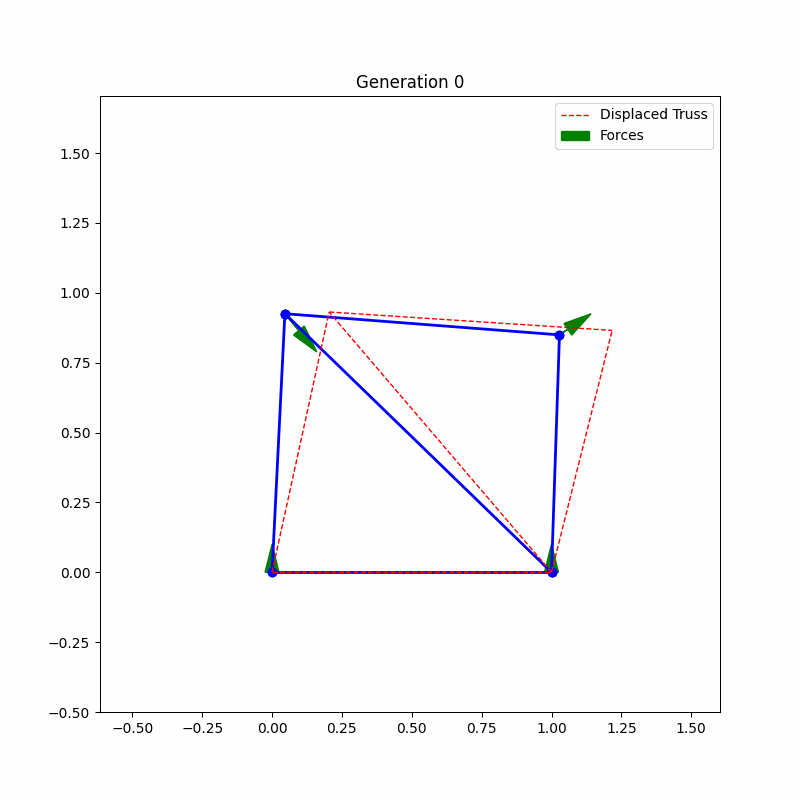

In [42]:
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import random
import imageio.v2 as imageio
import os
from IPython.display import display, Image

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# Optimization Parameters

# Beam Length limits
MIN_LENGTH = 0.5
MAX_LENGTH = 2.0

# Patience parameter, max iteration with no improvements
PATIENCE = 15
MUTATION_RATE = 0.15

#-------------------------------------------------------------------------------
# Plotting parameters
DEFORM_SCALE = 0.1
SHOW_TRACE   = 1

#-------------------------------------------------------------------------------

def generate_truss(points):
    tri = Delaunay(points)
    edges = set()
    for simplex in tri.simplices:
        for i in range(3):
            edge = tuple(sorted([simplex[i], simplex[(i + 1) % 3]]))
            xi, yi = points[edge[0]]
            xj, yj = points[edge[1]]
            length = np.sqrt((xj - xi) ** 2 + (yj - yi) ** 2)
            if MIN_LENGTH <= length <= MAX_LENGTH:
                edges.add(edge)
            else:
                print(f"Warning: Edge {edge} with length {length:.2f} is out of bounds. Length should be between {MIN_LENGTH} and {MAX_LENGTH}.")
    return list(edges)

def fem_analysis(points, edges, forces, fixed_points, E=1.0):
    num_points = len(points)
    num_dofs = 2 * num_points
    stiffness_matrix = np.zeros((num_dofs, num_dofs))
    force_vector = forces.flatten()

    # Build stiffness matrix
    for edge in edges:
        i, j = edge
        xi, yi = points[i]
        xj, yj = points[j]
        length = np.sqrt((xj - xi) ** 2 + (yj - yi) ** 2)
        c = (xj - xi) / length
        s = (yj - yi) / length
        k_local = E * np.array([[c * c, c * s, -c * c, -c * s],
                                [c * s, s * s, -c * s, -s * s],
                                [-c * c, -c * s, c * c, c * s],
                                [-c * s, -s * s, c * s, s * s]])
        k_global_indices = np.array([2 * i, 2 * i + 1, 2 * j, 2 * j + 1])
        for ii in range(4):
            for jj in range(4):
                stiffness_matrix[k_global_indices[ii], k_global_indices[jj]] += k_local[ii, jj]

    # Apply boundary conditions
    try:
        stiffness_matrix, force_vector, free_dofs = apply_boundary_conditions(stiffness_matrix, force_vector, fixed_points)
        displacement = np.linalg.solve(stiffness_matrix, force_vector)
    except np.linalg.LinAlgError:
        print("Generation: Singular matrix encountered, skipping...")
        return None

    # Re-add fixed point's displacement as zeros
    displacement_full = np.zeros(num_dofs)
    displacement_full[free_dofs] = displacement

    return displacement_full

def apply_boundary_conditions(stiffness_matrix, force_vector, fixed_points):
    fixed_dofs = []
    for p in fixed_points:
        fixed_dofs.extend([2 * p, 2 * p + 1])

    free_dofs = np.setdiff1d(np.arange(stiffness_matrix.shape[0]), fixed_dofs)
    stiffness_matrix_free = stiffness_matrix[np.ix_(free_dofs, free_dofs)]
    force_vector_free = force_vector[free_dofs]

    return stiffness_matrix_free, force_vector_free, free_dofs

def fitness(points, edges, forces, fixed_points, E=1.0):
    displacement = fem_analysis(points, edges, forces, fixed_points, E)
    if displacement is None:
        return float('inf'), float('inf'), float('inf')  # High fitness value to skip this solution

    displacement_penalty = np.linalg.norm(displacement)

    total_length = sum(np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2) for i, j in edges)
    material_penalty = total_length

    total_fitness = displacement_penalty**2 + material_penalty #################### Fitness Score Calculation
    return total_fitness, displacement_penalty, material_penalty

def crossover(parent1, parent2, fixed_points):
    child = np.copy(parent1)
    for i in range(len(parent1)):
        if i not in fixed_points:
            child[i] = (parent1[i] + parent2[i]) / 2
    return child

def mutate(points, fixed_points, mutation_rate=MUTATION_RATE):
    mutated_points = np.copy(points)
    for i in range(len(mutated_points)):
        if i not in fixed_points:
            if random.random() < mutation_rate:
                mutated_points[i] += mutation_rate * np.random.randn(2)
    return mutated_points

def save_truss_plot(points, edges, forces, generation, history=None, displacements=None, xlim=None, ylim=None, scale=DEFORM_SCALE):
    plt.figure(figsize=(8, 8))

    # Plot the original truss members
    for edge in edges:
        i, j = edge
        x = [points[i][0], points[j][0]]
        y = [points[i][1], points[j][1]]
        plt.plot(x, y, 'bo-', lw=2, label='Original Truss' if displacements is None else '_nolegend_')

    # Plot the displaced truss members if displacements are provided
    if displacements is not None:
        for edge in edges:
            i, j = edge
            x = [points[i][0] + scale * displacements[2*i], points[j][0] + scale * displacements[2*j]]
            y = [points[i][1] + scale * displacements[2*i+1], points[j][1] + scale * displacements[2*j+1]]
            plt.plot(x, y, 'r--', lw=1, label='Displaced Truss' if i == 0 and j == 1 else '_nolegend_')

    # Plot the forces as arrows
    for i, (fx, fy) in enumerate(forces):
        plt.arrow(points[i][0], points[i][1], 0.1 * fx, 0.1 * fy, head_width=0.05, head_length=0.1, fc='green', ec='green', label='Forces' if i == 0 else '_nolegend_')

    # Plot the history of points
    if history is not None:
        for gen in range(len(history)):
            pts = history[gen]
            plt.scatter(pts[:, 0], pts[:, 1], alpha=SHOW_TRACE, color='grey', s=10, label='_nolegend_')

    plt.legend()
    plt.axis('equal')
    if xlim and ylim:
        plt.xlim(xlim)
        plt.ylim(ylim)
    plt.title(f'Generation {generation}')
    plt.savefig(f'generation_{generation}.png')
    plt.close()

def genetic_algorithm(num_generations, population_size, points, forces, fixed_points, E=1.0, patience=PATIENCE):
    all_points = [np.copy(points) + 0.1 * np.random.randn(*points.shape) for _ in range(population_size)]

    # Ensure fixed points are not modified in the initial population
    for i in fixed_points:
        for individual in all_points:
            individual[i] = points[i]

    x_min, y_min = np.min([np.min(individual, axis=0) for individual in all_points], axis=0)
    x_max, y_max = np.max([np.max(individual, axis=0) for individual in all_points], axis=0)

    xlim = (x_min - 0.5, x_max + 0.5)
    ylim = (y_min - 0.5, y_max + 0.5)

    initial_positions = np.copy(points)
    population = all_points
    initial_fitness = None
    best_fitness = float('inf')
    no_improvement_count = 0

    # Store history of points for tracking
    history = []

    for generation in range(num_generations):
        population_fitness = []
        for individual in population:
            edges = generate_truss(individual)
            if not edges:
                continue  # Skip if no valid edges are found
            total_fitness, displacement_penalty, material_penalty = fitness(individual, edges, forces, fixed_points, E)
            population_fitness.append((total_fitness, displacement_penalty, material_penalty, individual))

        if not population_fitness:
            print(f"Generation {generation}: No valid truss configurations found, skipping...")
            continue

        population_fitness.sort(key=lambda x: x[0])

        if initial_fitness is None:
            initial_fitness = population_fitness[0][0]

        normalized_fitness      = [f[0] / initial_fitness for f in population_fitness]
        normalized_displacement = [f[1] / initial_fitness for f in population_fitness]
        normalized_material     = [f[2] / initial_fitness for f in population_fitness]

        best_fitness_this_gen   = population_fitness[0][0]
        normalized_best_fitness = best_fitness_this_gen / initial_fitness

        if normalized_best_fitness < best_fitness:
            best_fitness = normalized_best_fitness
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        best_individual   = population_fitness[0][3]
        best_edges        = generate_truss(best_individual)
        best_displacement = fem_analysis(best_individual, best_edges, forces, fixed_points, E)

        # Save the history of points
        history.append(np.copy(best_individual))

        if best_displacement is not None:
            save_truss_plot(best_individual, best_edges, forces, generation, history=history, displacements=best_displacement, xlim=xlim, ylim=ylim, scale=DEFORM_SCALE)

        print(f"Generation {generation}: Best Fitness = {normalized_best_fitness:.2f}, "
              f"Displacement Fitness = {normalized_displacement[0]:.2f}, "
              f"Material Usage Fitness = {normalized_material[0]:.2f}, "
              f"Points = {best_individual.tolist()}")

        if no_improvement_count >= patience:
            print(f"Generation {generation}: No improvement after {patience} generations, stopping...")
            break

        selected_population = [individual for _, _, _, individual in population_fitness[:population_size // 2]]

        new_population = []
        while len(new_population) < population_size:
            parents = random.sample(selected_population, 2)
            child = crossover(parents[0], parents[1], fixed_points)
            child = mutate(child, fixed_points)
            # Ensure fixed points in the child remain fixed
            for i in fixed_points:
                child[i] = points[i]
            new_population.append(child)

        population = new_population

    return best_individual

def create_gif(num_generations):
    images = []
    for generation in range(num_generations):
        filename = f'generation_{generation}.png'
        if os.path.exists(filename):
            images.append(imageio.imread(filename))
    if images:
        imageio.mimsave('optimization_process.gif', images, duration=0.9, loop=0)

#-------------------------------------------------------------------------------
#-------------------------------------------------------------------------------
# Example usage:

!rm -rf generation_*

# points must be at least 3
initial_points = np.array([[0, 0], [1, 0], [0, 1],      [1, 1]])
forces         = np.array([[0, 0], [0, 0], [0.5, -0.6], [0.3, 0.2]])
fixed_points   = [0, 1] #The structure can't be free or in a singular config.

pop_size = 50
n_gens   = 100

best_points = genetic_algorithm(num_generations=n_gens, population_size=pop_size, points=initial_points, forces=forces, fixed_points=fixed_points, E=1, patience=PATIENCE)
create_gif(num_generations=n_gens)
gif_path = 'optimization_process.gif'
display(Image(filename=gif_path))
